# PDF of surface vorticity and strain in eNATL60 simulation with tides and no tides in ACORES region 

__author__ : Aurélie Albert, Julien Le Sommer (MEOM), Andy Hogg (ANU)

__context__ : paper "On the momentum flux of internal tides" by Shakespeare & Hogg

__date__ : March 2019

__purpose__ : distribution of surface vorticity and strain values in eNATL60 simulation with tides and no tides in the ACORES region,velocities are first filtered so frequency higher than 0.9 times Coriolis frequency are removed. 

__detailed description__ : 
Vorticity is defined as :

$$curl = \partial{_x}{v} - \partial{_y}{u} $$

Strain is defined as :

$$strain = \sqrt{ (\partial{_x}{v}+\partial{_y}{u})^2 + (\partial{_x}{u}-\partial{_y}{v})^2 } $$

Both quantities are scale by f.

__practical steps__ :

  * Input data are hourly surface currents from eNATL60-BLB002 simulation (no-tide) and eNTAL60-BLBT02 simulation (tide) 
  
  * Frequency higher than Coriolis (~17h) are filtered for U and V
  
  * Surface vorticity and strain over f are computed 
  
 
__licence__ : This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

In [5]:
## path for mdules

import sys
#sys.path.insert(0,"/home/albert/lib/python")

import numpy as np
import xarray as xr
import glob

from netCDF4 import Dataset

sys.path.insert(0,"/home/henelle/Notebooks/git/xscale")
import xscale
import xscale.spectral.fft as xfft

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import numpy.ma as ma

import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

import matplotlib.pyplot as plt
from datetime import date

import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

In [2]:
## Dataset

dirtide="/mnt/albert/equipes/IGE/meom/MODEL_SET/eNATL60/eNATL60-BLBT02-S/1h/ACO/"
dirnotide="/mnt/albert/equipes/IGE/meom/MODEL_SET/eNATL60/eNATL60-BLB002-S/1h/ACO/"

dirtidefilt="/mnt/albert/equipes/IGE/meom/workdir/albert/eNATL60/eNATL60-BLBT02-S/1h/ACO/"
dirnotidefilt="/mnt/albert/equipes/IGE/meom/workdir/albert/eNATL60/eNATL60-BLB002-S/1h/ACO/"



In [11]:
tfilecurltide=dirtide+'eNATL60ACO-BLBT02_1h_20090710-20090809_socurloverf.nc'
tfilestraintide=dirtide+'eNATL60ACO-BLBT02_1h_20090710-20090809_sostrainoverf.nc'
tfilecurlnotide=dirnotide+'eNATL60ACO-BLB002_1h_20090710-20090809_socurloverf.nc'
tfilestrainnotide=dirnotide+'eNATL60ACO-BLB002_1h_20090710-20090809_sostrainoverf.nc'

!ls $tfilecurlnotide
!ls $tfilestraintide

/mnt/albert/equipes/IGE/meom/MODEL_SET/eNATL60/eNATL60-BLB002-S/1h/ACO/eNATL60ACO-BLB002_1h_20090710-20090809_socurloverf.nc
/mnt/albert/equipes/IGE/meom/MODEL_SET/eNATL60/eNATL60-BLBT02-S/1h/ACO/eNATL60ACO-BLBT02_1h_20090710-20090809_sostrainoverf.nc


In [4]:
tfilecurltidefilt=dirtidefilt+'eNATL60ACO-BLBT02_1h_20090710_20090809_socurloverf_filt.nc'
tfilestraintidefilt=dirtidefilt+'eNATL60ACO-BLBT02_1h_20090710_20090809_sostrainoverf_filt.nc'
tfilecurlnotidefilt=dirnotidefilt+'eNATL60ACO-BLB002_1h_20090710_20090809_socurloverf_filt.nc'
tfilestrainnotidefilt=dirnotidefilt+'eNATL60ACO-BLB002_1h_20090710_20090809_sostrainoverf_filt.nc'


!ls $tfilecurlnotidefilt
!ls $tfilestraintidefilt

/mnt/albert/equipes/IGE/meom/workdir/albert/eNATL60/eNATL60-BLB002-S/1h/ACO/eNATL60ACO-BLB002_1h_20090710_20090809_socurloverf_filt.nc
/mnt/albert/equipes/IGE/meom/workdir/albert/eNATL60/eNATL60-BLBT02-S/1h/ACO/eNATL60ACO-BLBT02_1h_20090710_20090809_sostrainoverf_filt.nc


In [5]:
def plot_surf(sub,data,lon,lat,vmin,vmax,cmap,title,date):
    
    ax = plt.subplot(sub,projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent((-36, -26, 25, 40))
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor=cfeature.COLORS['land'])
    ax.add_feature(land)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.pcolormesh(lon,lat,data,cmap=cmap,vmin=vmin,vmax=vmax )
    plt.colorbar(orientation='horizontal',pad=0.1)
    plt.title(title)
    ax.text(0.57, -0.08, date, transform=ax.transAxes)

    ax.plot([-31, -28], [33, 33],color='black',linewidth=4)
    ax.plot([-31, -28], [36, 36],color='black',linewidth=4)
    ax.plot([-31, -31], [33, 36],color='black',linewidth=4)
    ax.plot([-28, -28], [33, 36],color='black',linewidth=4)


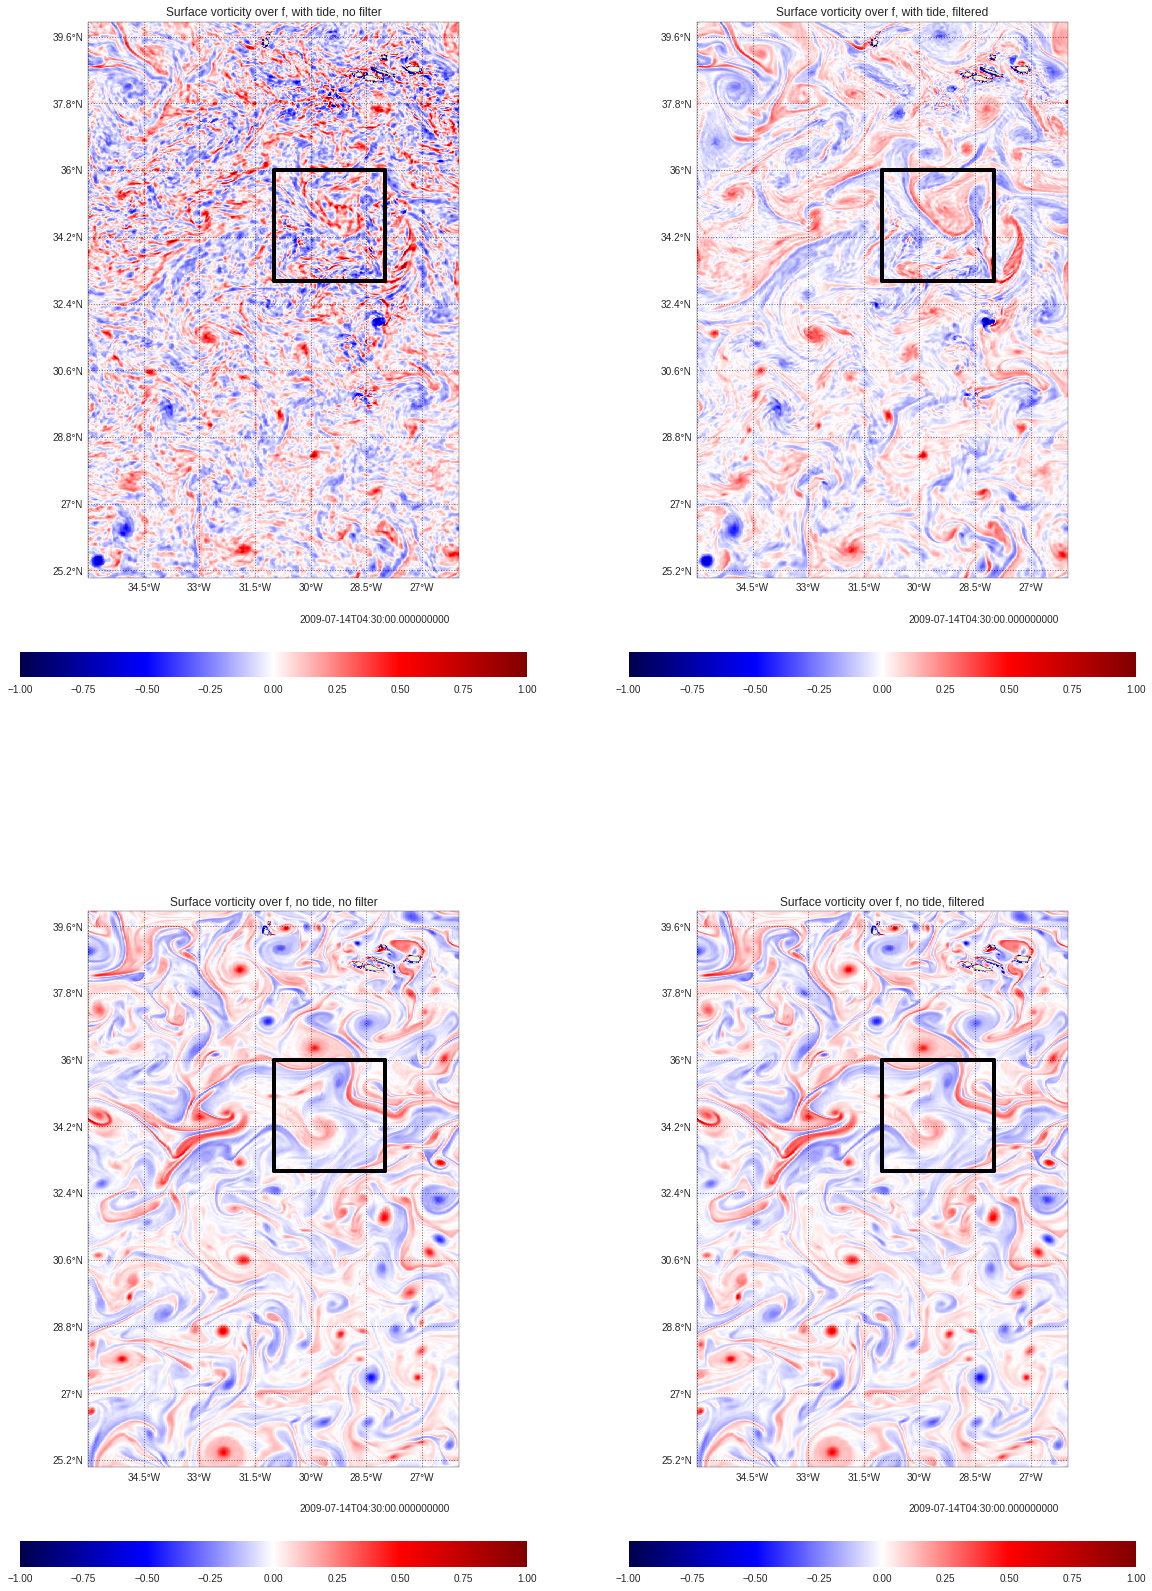

In [14]:
fig=plt.figure(figsize=(20,30))

fcurltide = xr.open_dataset(tfilecurltide)
curltide=fcurltide['socurloverf'][100]
navlat= fcurltide['nav_lat']
navlon= fcurltide['nav_lon']
plot_surf(221,curltide,navlon,navlat,-1,1,div_cmap,'Surface vorticity over f, with tide, no filter',str(curltide.time_counter.values))

fcurlnotide = xr.open_dataset(tfilecurlnotide)
curlnotide=fcurlnotide['socurloverf'][100]
plot_surf(223,curlnotide,navlon,navlat,-1,1,div_cmap,'Surface vorticity over f, no tide, no filter',str(curlnotide.time_counter.values))

fcurltidefilt = xr.open_dataset(tfilecurltidefilt)
curltidefilt=fcurltidefilt['socurloverf'][100]
plot_surf(222,curltidefilt,navlon,navlat,-1,1,div_cmap,'Surface vorticity over f, with tide, filtered',str(curltidefilt.time_counter.values))

fcurlnotidefilt = xr.open_dataset(tfilecurlnotidefilt)
curlnotidefilt=fcurlnotidefilt['socurloverf'][100]
plot_surf(224,curlnotidefilt,navlon,navlat,-1,1,div_cmap,'Surface vorticity over f, no tide, filtered',str(curlnotidefilt.time_counter.values))


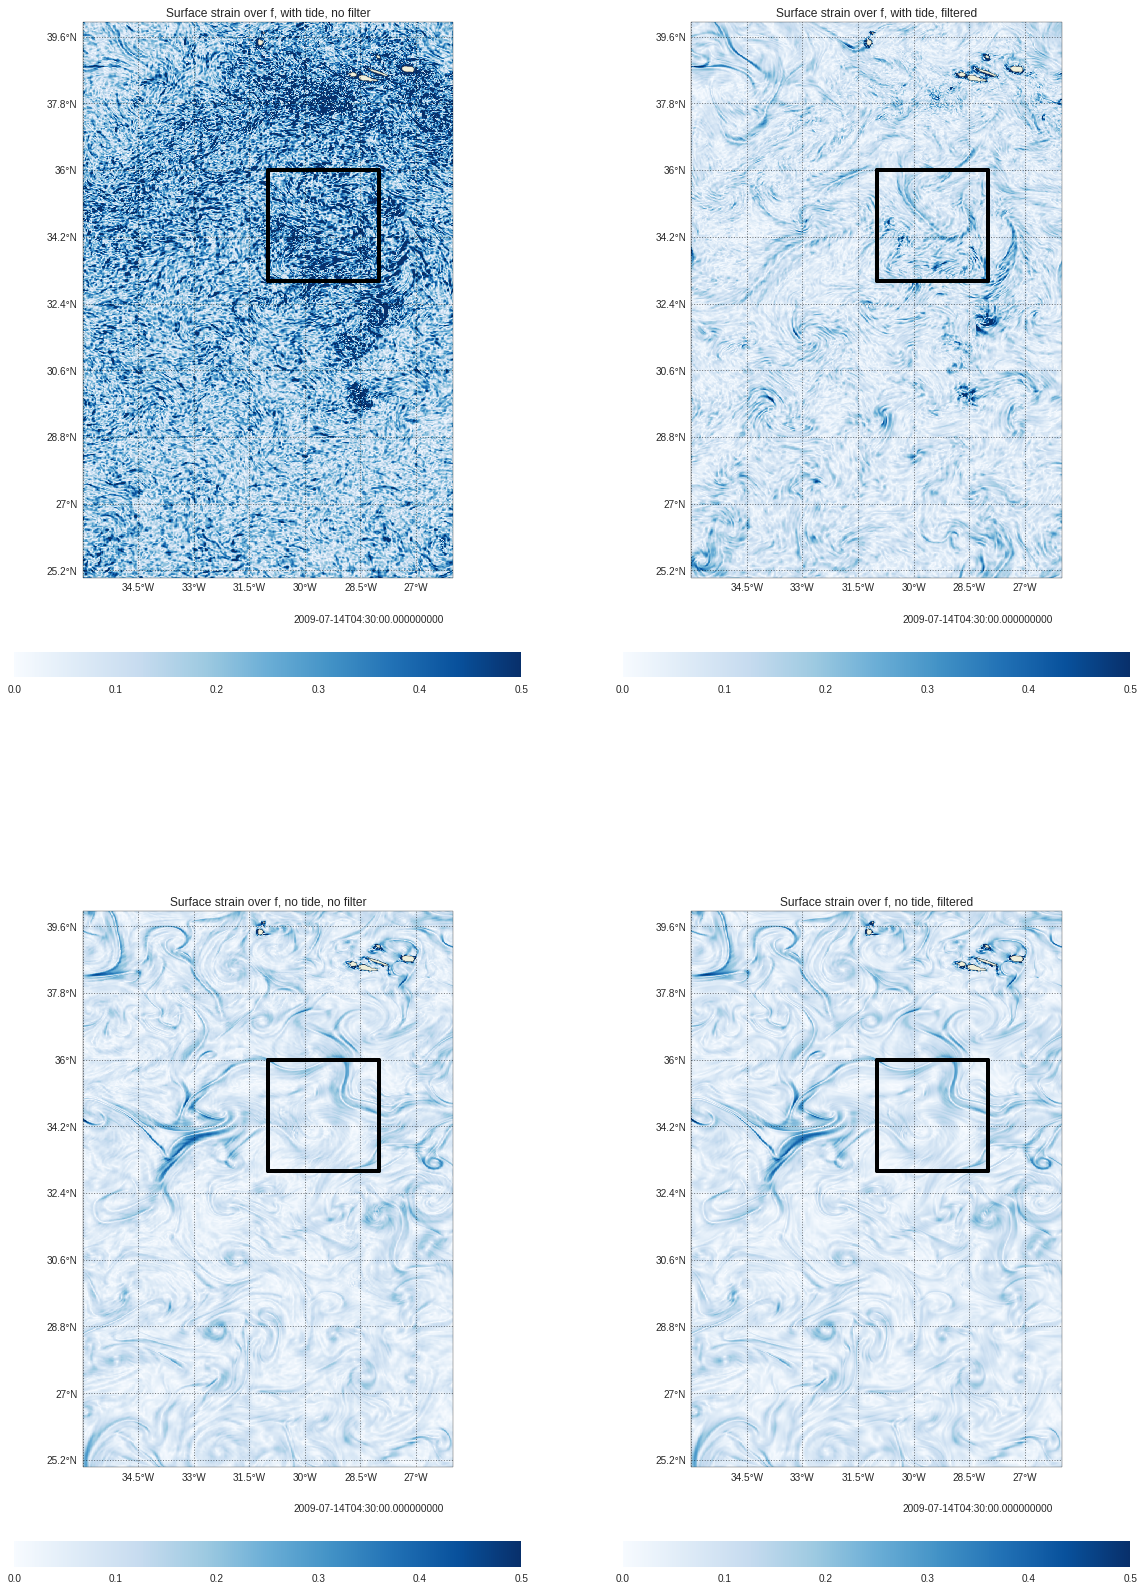

In [15]:
fig=plt.figure(figsize=(20,30))

fstraintide = xr.open_dataset(tfilestraintide)
straintide=fstraintide['sostrainoverf'][100]
navlat= fstraintide['nav_lat']
navlon= fstraintide['nav_lon']
plot_surf(221,straintide,navlon,navlat,0,0.5,seq_cmap,'Surface strain over f, with tide, no filter',str(straintide.time_counter.values))

fstrainnotide = xr.open_dataset(tfilestrainnotide)
strainnotide=fstrainnotide['sostrainoverf'][100]
plot_surf(223,strainnotide,navlon,navlat,0,0.5,seq_cmap,'Surface strain over f, no tide, no filter',str(strainnotide.time_counter.values))

fstraintidefilt = xr.open_dataset(tfilestraintidefilt)
straintidefilt=fstraintidefilt['sostrainoverf'][100]
plot_surf(222,straintidefilt,navlon,navlat,0,0.5,seq_cmap,'Surface strain over f, with tide, filtered',str(straintidefilt.time_counter.values))

fstrainnotidefilt = xr.open_dataset(tfilestrainnotidefilt)
strainnotidefilt=fstrainnotidefilt['sostrainoverf'][100]
plot_surf(224,strainnotidefilt,navlon,navlat,0,0.5,seq_cmap,'Surface strain over f, no tide, filtered',str(strainnotidefilt.time_counter.values))


In [16]:
box=(-31,-28,33,36)
domain=(box[0]<navlon)*(navlon<box[1])*(box[2]<navlat)*(navlat<box[3])
where=np.where(domain)

lats=navlat[where]
lons=navlon[where]

ind = np.unravel_index(np.argmin(lats, axis=None), lats.shape)
jmin = where[0][ind[0]]
ind = np.unravel_index(np.argmax(lats, axis=None), lats.shape)
jmax = where[0][ind[0]]
ind = np.unravel_index(np.argmin(lons, axis=None), lons.shape)
imin = where[1][ind[1]]
ind = np.unravel_index(np.argmax(lons, axis=None), lons.shape)
imax = where[1][ind[1]]

curltidefiltbox=curltidefilt[jmin:jmax+1,imin:imax+1].stack(z=('x', 'y'))
curlnotidefiltbox=curlnotidefilt[jmin:jmax+1,imin:imax+1].stack(z=('x', 'y'))
straintidefiltbox=straintidefilt[jmin:jmax+1,imin:imax+1].stack(z=('x', 'y'))
strainnotidefiltbox=strainnotidefilt[jmin:jmax+1,imin:imax+1].stack(z=('x', 'y'))

weights_curltidefilt = np.ones_like(curltidefiltbox)/float(len(curltidefiltbox))
weights_curlnotidefilt = np.ones_like(curlnotidefiltbox)/float(len(curlnotidefiltbox))
weights_straintidefilt = np.ones_like(straintidefiltbox)/float(len(straintidefiltbox))
weights_strainnotidefilt = np.ones_like(strainnotidefiltbox)/float(len(strainnotidefiltbox))



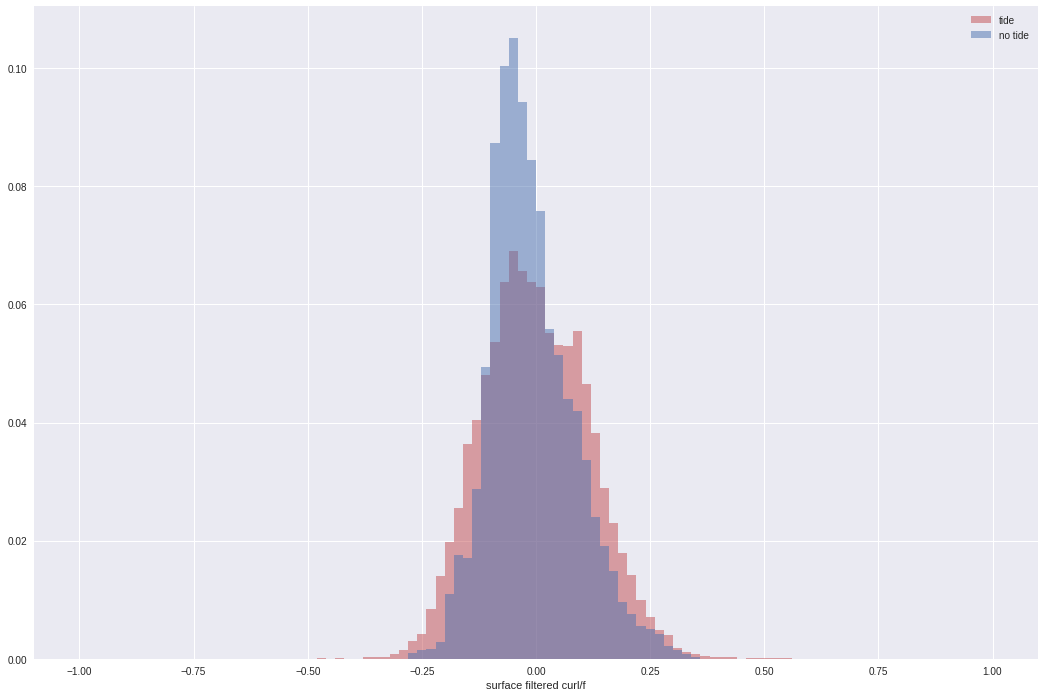

In [17]:
fig = plt.figure(figsize=(18.0, 12.0))
axes1 = fig.add_subplot(1, 1, 1)

axes1.hist(curltidefiltbox,100, alpha = 0.5,range=(-1,1),color='r', weights=weights_curltidefilt,label='tide')
axes1.hist(curlnotidefiltbox,100, alpha = 0.5,range=(-1,1),color='b', weights=weights_curlnotidefilt, label='no tide')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('surface filtered curl/f')
plt.legend()


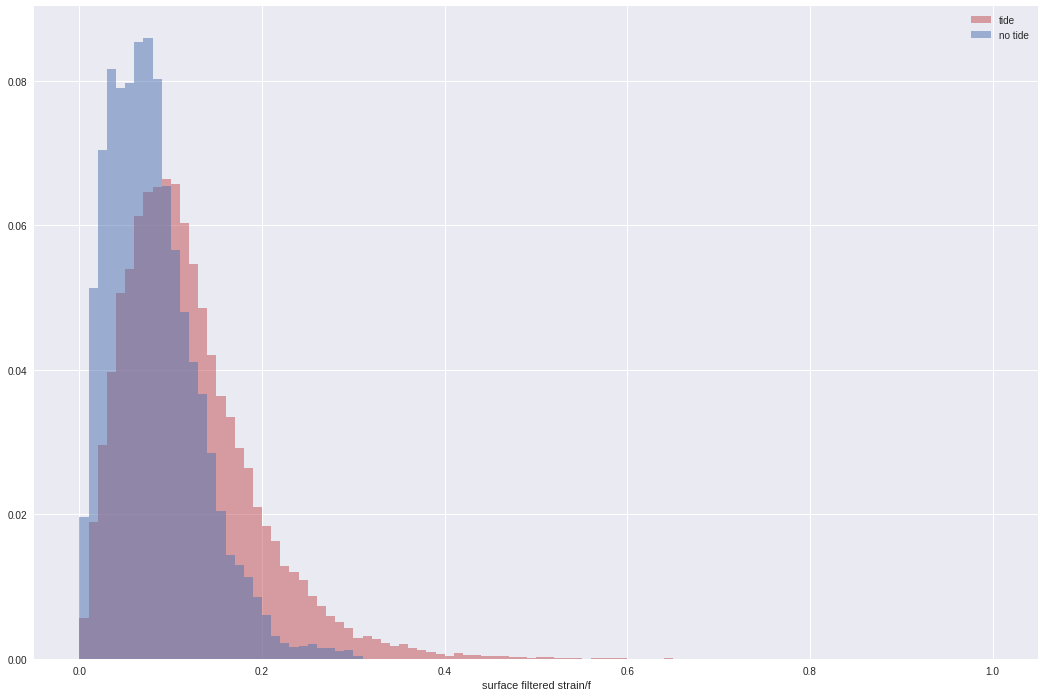

In [18]:
fig = plt.figure(figsize=(18.0, 12.0))
axes1 = fig.add_subplot(1, 1, 1)

axes1.hist(straintidefiltbox,100, alpha = 0.5,range=(0,1),color='r', weights=weights_straintidefilt,label='tide')
axes1.hist(strainnotidefiltbox,100, alpha = 0.5,range=(0,1),color='b', weights=weights_strainnotidefilt, label='no tide')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('surface filtered strain/f')
plt.legend()
